In [20]:
!git clone https://github.com/dacarlin/protein-transformers-from-scratch.git

Cloning into 'protein-transformers-from-scratch'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 15), reused 19 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 4.20 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [21]:
%cd /content/protein-transformers-from-scratch/

/content/protein-transformers-from-scratch


In [22]:
!pip install python-Levenshtein


In [23]:
# 1. imports

!pip install biotite plotly nbformat

import plotly.express as px
from biotite.sequence.io.fasta import FastaFile

In [24]:
# 1. imports

import math
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from biotite.sequence.io.fasta import FastaFile


torch.manual_seed(12)
random.seed(42)

In [25]:
# 2. input file

# uniprot "acylphosphatase family > with active site annotation > length less than 200 > to fasta"

# look at the file on disk

input_file = "./fasta/raw.fa"

! head "$input_file"

>tr|A0A0Q0WE68|A0A0Q0WE68_9EURY acylphosphatase OS=Methanosaeta sp. SDB OX=1735328 GN=APR56_14035 PE=3 SV=1
MKRVDIIASGDVQKVGFRDVVQKIGRDLGLSGTVENREPYDVRIVAEGEEDGLKEFIEAL
KIKRGPIHVRELEVSWSEATGEFPYFKILRGDWQEELGERFDVAVGLLYRSIEIGEENLA
LGRENLALGKENLAVSKENLAIGKKMLEKQDTMIERQDETIGEIRGMRSDFQDHMEKRFT
KIEGEIAEIKAAIADIKGNA
>tr|A0A1S3CGZ8|A0A1S3CGZ8_CUCME acylphosphatase OS=Cucumis melo OX=3656 GN=LOC103500820 PE=3 SV=1
MASASSSSSAAFAVGPLIRNRSTRFLPCRNLHHKWSFKDAGSHSRLSLFNYYNSSPLLPS
LPIRHRLLLPHPPLHLLLRSRSPSFRYPLPLMASTVPHQAGPETPQSNPTKTVRVVIKGR
VQGVFYRDWTVENATELGLKGWVRNRRDGSVEALFSGRPESVTEMEQRCRRGPPAAMVTG
FQVFPSSDDPGPGFERLRTA


In [26]:
# 3. save the FASTA headers, the sequences, and the sequence lengths

fn = FastaFile.read(input_file)

headers = []
sequences = []
lengths = []

for header, sequence in fn.items():

    header = header.split("|")[1]
    sequence = str(sequence)
    length = len(sequence)

    headers.append(header)
    sequences.append(sequence)
    lengths.append(length)

print(f"Read {len(headers)} sequences")

sequences[:2]

Read 28856 sequences


['MKRVDIIASGDVQKVGFRDVVQKIGRDLGLSGTVENREPYDVRIVAEGEEDGLKEFIEALKIKRGPIHVRELEVSWSEATGEFPYFKILRGDWQEELGERFDVAVGLLYRSIEIGEENLALGRENLALGKENLAVSKENLAIGKKMLEKQDTMIERQDETIGEIRGMRSDFQDHMEKRFTKIEGEIAEIKAAIADIKGNA',
 'MASASSSSSAAFAVGPLIRNRSTRFLPCRNLHHKWSFKDAGSHSRLSLFNYYNSSPLLPSLPIRHRLLLPHPPLHLLLRSRSPSFRYPLPLMASTVPHQAGPETPQSNPTKTVRVVIKGRVQGVFYRDWTVENATELGLKGWVRNRRDGSVEALFSGRPESVTEMEQRCRRGPPAAMVTGFQVFPSSDDPGPGFERLRTA']

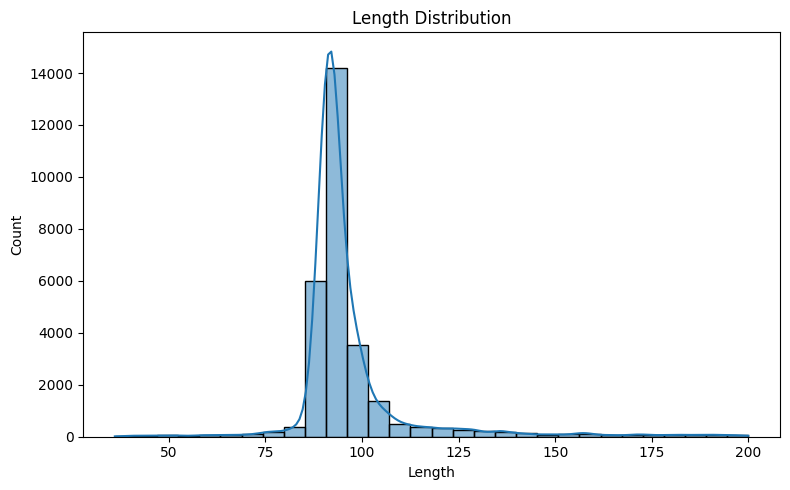

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("images", exist_ok=True)

plt.figure(figsize=(8, 5))
sns.histplot(lengths, bins=30, kde=True)
plt.title("Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/content/protein-transformers-from-scratch/images/length_distribution2.png", dpi=300)
plt.show()
plt.close()


In [30]:
# 2. define a Torch dataset class for our data

class ProteinDataset(Dataset):
    """Dataset for protein sequences with character-level tokenization"""

    def __init__(self, proteins, chars, max_protein_length):
        """Create a dataset

        proteins: list of str, protein sequences
        chars: list of str, all the characters in the vocabulary
        max_protein_length: int, the length of the longest sequence
        """
        self.proteins = proteins
        self.chars = chars
        self.max_protein_length = max_protein_length
        self.stoi = {ch: i + 1 for i, ch in enumerate(chars)}
        self.itos = {i: s for s, i in self.stoi.items()} # inverse mapping

    def __len__(self):
        return len(self.proteins)

    def contains(self, protein):
        return protein in self.proteins

    def get_vocab_size(self):
        return len(self.chars) + 1 # all the possible characters and special 0 token

    def get_output_length(self):
        return self.max_protein_length + 1 # <START> token followed by proteins

    def encode(self, protein):
        ix = torch.tensor([self.stoi[w] for w in protein], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        protein = self.proteins[idx]
        ix = self.encode(protein)
        x = torch.zeros(self.max_protein_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_protein_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 # index -1 will mask the loss at the inactive locations
        return x, y

In [31]:
# 3. dataset example, some short proteins of length 38

proteins = [
    "MCLLSLAAATVAARRTPLRLLGRGLAAAMSTAGPLKSV",
    "MSSQIKKSKTTTKKLVKSAPKSVPNAAADDQIFCCQFE",
    "MCLLSLAAATVAARRTPLRLLGRGLAAAMSTAGPLKSV",
]

chars = "ACDEFGHIKLMNPQRSTVWY"

max_length = 38

dataset = ProteinDataset(proteins, chars, max_length)

x, y = dataset[0]

x

tensor([ 0, 11,  2, 10, 10, 16, 10,  1,  1,  1, 17, 18,  1,  1, 15, 15, 17, 13,
        10, 15, 10, 10,  6, 15,  6, 10,  1,  1,  1, 11, 16, 17,  1,  6, 13, 10,
         9, 16, 18])

In [32]:
# 4. now wrap this logic into a nice function

def create_datasets(input_file):
    """Create train and test datasets from a FASTA file (90/10 split)"""

    # preprocessing of the input text file
    proteins = []
    fasta_file = FastaFile.read(input_file)
    for header, sequence in fasta_file.items():
        proteins.append(sequence)
    max_protein_length = max(len(w) for w in proteins)

    # partition the input data into a training and the test set
    test_set_size = int(len(proteins) * 0.1) # 10% of the training set
    rp = torch.randperm(len(proteins)).tolist()
    train_proteins = [proteins[i] for i in rp[:-test_set_size]]
    test_proteins = [proteins[i] for i in rp[-test_set_size:]]
    print(f"Split up the dataset into {len(train_proteins)} training examples and {len(test_proteins)} test examples")

    chars = sorted(list(set(''.join(proteins)))) # all the possible characters
    tokens = sum(len(w) for w in proteins)

    print(f"Number of examples in the dataset: {len(proteins)}")
    print(f"Max protein length: {max_protein_length}")
    print(f"Number of unique characters in the vocabulary: {len(chars)}")
    print(f"Vocabulary (amino acids): {''.join(chars)}")
    print(f"Total tokens: {tokens}")

    # wrap in dataset objects
    train_dataset = ProteinDataset(train_proteins, chars, max_protein_length)
    test_dataset = ProteinDataset(test_proteins, chars, max_protein_length)

    return train_dataset, test_dataset

In [33]:
# 5. example of using this on our dataset

input_file = "./fasta/raw.fa"

train_dataset, test_dataset = create_datasets(input_file)

x, y = train_dataset[0]

x

Split up the dataset into 25971 training examples and 2885 test examples
Number of examples in the dataset: 28856
Max protein length: 200
Number of unique characters in the vocabulary: 21
Vocabulary (amino acids): ACDEFGHIKLMNPQRSTVWXY
Total tokens: 2791739


tensor([ 0, 11, 18, 15, 15, 18, 16,  1, 21, 21, 16,  6, 11, 18, 14,  6, 18,  6,
         5, 15,  5, 17,  1,  4, 16,  8,  1,  6,  3, 10,  6, 18, 15,  6, 19, 18,
         9, 12, 10, 15,  3,  6, 15, 18,  4,  8, 18,  1,  4,  1,  4,  4,  6,  1,
        10,  9,  3,  5, 10,  6, 15,  8,  4, 14, 16, 10, 16, 15, 21,  8, 15,  3,
         1,  3, 18,  9, 19, 14,  4, 13, 17,  6,  4,  5, 16,  4,  5, 15,  8,  1,
         5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])

In [34]:
# 6. ok so to get started, let's keep good habits and record all our params in one place!

@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    n_layer: int = 4
    embed_dim: int = 64
    n_head: int = 4
    learning_rate: float = 4e-3
    batch_size: int = 32
    device = "cuda"
    max_steps = 20_000


config = ModelConfig()

In [35]:
# 7. define the whole transformer model

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """

    def forward(self, x):
        return (0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0)))))


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.embed_dim % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.embed_dim, 3 * config.embed_dim)
        # output projection
        self.c_proj = nn.Linear(config.embed_dim, config.embed_dim)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.embed_dim = config.embed_dim

    def forward(self, x):
        B, T, C = (x.size())

        # Calculate querys, keys, values for all heads in batch, using head dim as additional batch dimension
        q, k, v = self.c_attn(x).split(self.embed_dim, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, head_size)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, head_size)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, head_size)

        # Causal self-attention: (B, nh, T, hs) @ (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) @ (B, nh, T, hs) -> (B, nh, T, hs)
        y = (y.transpose(1, 2).contiguous().view(B, T, C))  # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y


class Block(nn.Module):
    """an unassuming Transformer block"""

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.mlp = nn.ModuleDict(
            dict(
                c_fc=nn.Linear(config.embed_dim, 4 * config.embed_dim),
                c_proj=nn.Linear(4 * config.embed_dim, config.embed_dim),
                act=NewGELU(),
            )
        )
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x)))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x


class Transformer(nn.Module):
    """Transformer Language Model, exactly as seen in GPT-2"""

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.embed_dim),
                wpe=nn.Embedding(config.block_size, config.embed_dim),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.embed_dim),
            )
        )
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params / 1e6,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert (
            t <= self.block_size
        ), f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, embed_dim)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, embed_dim)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
            )

        return logits, loss

In [36]:
# 8. example of making a tiny model

config.block_size = train_dataset.get_output_length()
config.vocab_size = train_dataset.get_vocab_size()
model = Transformer(config)

model

number of parameters: 0.21M


Transformer(
  (transformer): ModuleDict(
    (wte): Embedding(22, 64)
    (wpe): Embedding(201, 64)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=64, out_features=192, bias=True)
          (c_proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
          (c_proj): Linear(in_features=256, out_features=64, bias=True)
          (act): NewGELU()
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_features=22, bias=False)
)

In [37]:
# 9. ok so now let's do a basic training loop

# move model to torch device
model.to(config.device)

# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.99), eps=1e-8)

# create batch dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    sampler=torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=int(1e10)),
    pin_memory=True,
)

# training loop
step = 0
for batch in train_loader:

    # get the next batch, ship to device, and unpack it to input and target
    batch = [t.to(config.device) for t in batch]
    X, Y = batch

    # feed into the model
    logits, loss = model(X, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # logging
    if step % 1_000 == 0:
        print(f"step {step:,}/{config.max_steps:,} | loss {loss.item():.4f}")

    step += 1

    # termination conditions
    if config.max_steps >= 0 and step >= config.max_steps:
        break

step 0/20,000 | loss 3.2140
step 1,000/20,000 | loss 1.7086
step 2,000/20,000 | loss 1.2511
step 3,000/20,000 | loss 1.6353
step 4,000/20,000 | loss 1.3722
step 5,000/20,000 | loss 1.2235
step 6,000/20,000 | loss 1.4637
step 7,000/20,000 | loss 1.4039
step 8,000/20,000 | loss 1.4729
step 9,000/20,000 | loss 1.2254
step 10,000/20,000 | loss 1.3800
step 11,000/20,000 | loss 1.3271
step 12,000/20,000 | loss 1.3148
step 13,000/20,000 | loss 1.4328
step 14,000/20,000 | loss 1.4296
step 15,000/20,000 | loss 1.3179
step 16,000/20,000 | loss 1.3987
step 17,000/20,000 | loss 1.1770
step 18,000/20,000 | loss 1.2474
step 19,000/20,000 | loss 1.2120


In [38]:
# 10. generate from this model

@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either take most likely (greedy) or sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)  # (B, T + 1)

    return idx


def print_samples(num=10):
    """ samples from the model and pretty prints the decoded samples """
    X_init = torch.zeros(num, 1, dtype=torch.long).to(config.device)
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps).to('cpu')

    samples = []
    for i in range(X_samp.size(0)):
        # get the i'th row of sampled integers, as python list
        row = X_samp[i, 1:].tolist() # note: we need to crop out the first <START> token
        # token 0 is the <STOP> token, so we crop the output sequence at that point
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        protein_samp = train_dataset.decode(row)
        samples.append(protein_samp)

    for i, protein in enumerate(samples):
        header = f"sample_{i + 1}"
        print(f">{header}\n{protein}")

In [39]:
# Cell 1: Evaluate on Test Set
@torch.no_grad()
def evaluate_model(model, test_loader, config):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    for batch in test_loader:
        batch = [t.to(config.device) for t in batch]
        X, Y = batch
        logits, loss = model(X, Y)
        # Count non-ignored tokens
        mask = Y != -1
        total_tokens += mask.sum().item()
        total_loss += loss.item() * mask.sum().item()
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(avg_loss)
    print(f"Test Loss: {avg_loss:.4f} | Perplexity: {perplexity:.2f}")
    return avg_loss, perplexity

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    pin_memory=True
)

test_loss, test_perplexity = evaluate_model(model, test_loader, config)

Test Loss: 1.3831 | Perplexity: 3.99


In [40]:
# Cell 12: Generate Improved Samples
@torch.no_grad()
def generate_improved(model, dataset, num_samples=100, temperature=0.8):
    model.eval()
    max_len = dataset.get_output_length() - 1
    X_init = torch.zeros(num_samples, 1, dtype=torch.long).to(config.device)
    generated = generate(model, X_init, max_len, temperature=temperature).cpu()

    samples = []
    for row in generated[:, 1:].tolist():
        if 0 in row:
            row = row[:row.index(0)]
        protein = dataset.decode(row)
        if protein and 10 <= len(protein) <= dataset.max_protein_length:  # فیلتر منطقی
            samples.append(protein)

    print(f"Generated {len(samples)} valid proteins (filtered by length)")
    return samples

# Generate 100 samples
generated_proteins = generate_improved(model, train_dataset, num_samples=100, temperature=0.8)

Generated 100 valid proteins (filtered by length)


In [42]:
# Cell 13: Length Distribution Plot
import plotly.graph_objects as go

real_lengths = [len(p) for p in sequences]
gen_lengths = [len(p) for p in generated_proteins]

fig = go.Figure()
fig.add_trace(go.Histogram(x=real_lengths, name='Real', opacity=0.6, nbinsx=40))
fig.add_trace(go.Histogram(x=gen_lengths, name='Generated', opacity=0.6, nbinsx=40))
fig.update_layout(
    title="Protein Length Distribution: Real vs Generated",
    xaxis_title="Sequence Length",
    yaxis_title="Count",
    barmode='overlay',
    bargap=0.1,
    width=900, height=500
)
fig.show()

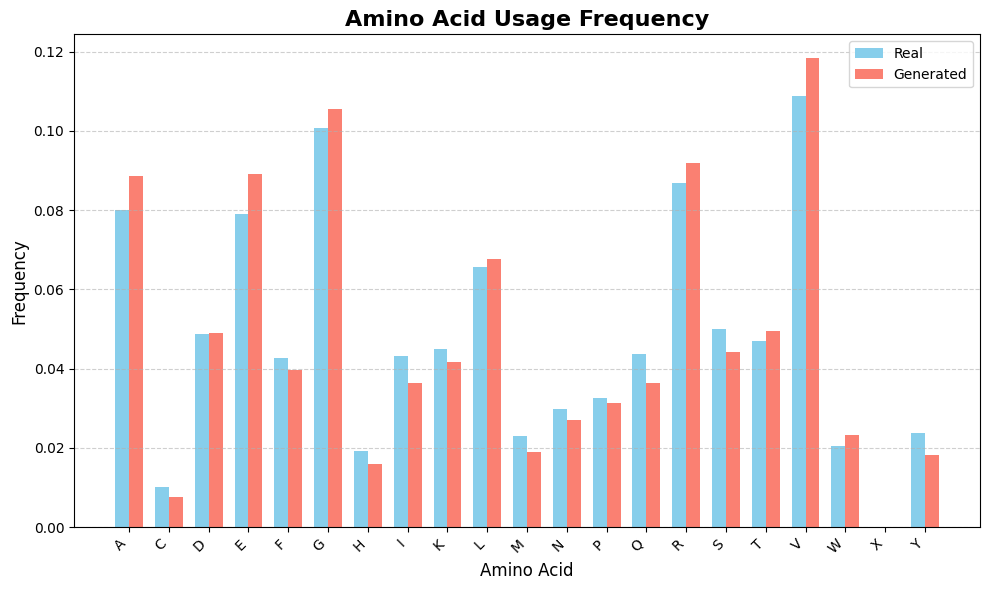

In [61]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

# مطمئن شدن از وجود پوشه 'images' برای ذخیره
os.makedirs("images", exist_ok=True)

# تابع محاسبه فراوانی (بدون تغییر)
def aa_frequency(proteins):
    counter = Counter(''.join(proteins))
    total = sum(counter.values())
    return {aa: count/total for aa, count in counter.items()}

# محاسبه فراوانی (بدون تغییر)
real_freq = aa_frequency(sequences)
gen_freq = aa_frequency(generated_proteins)

aa_order = sorted(real_freq.keys())
real_vals = [real_freq.get(aa, 0) for aa in aa_order]
gen_vals = [gen_freq.get(aa, 0) for aa in aa_order]

# --- تبدیل به Matplotlib ---

fig, ax = plt.subplots(figsize=(10, 6))

# تنظیمات نمودار میله‌ای
x = np.arange(len(aa_order))  # مکان‌های گروه‌ها
width = 0.35  # عرض میله‌ها

# رسم میله‌ها
rects1 = ax.bar(x - width/2, real_vals, width, label='Real', color='skyblue')
rects2 = ax.bar(x + width/2, gen_vals, width, label='Generated', color='salmon')

# تنظیم محورها و عنوان‌ها
ax.set_title("Amino Acid Usage Frequency", fontsize=16, fontweight='bold')
ax.set_xlabel("Amino Acid", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(aa_order, rotation=45, ha='right') # چرخاندن برای خوانایی بهتر
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

# ذخیره نمودار به عنوان فایل PNG (بخش حیاتی برای نمایش پایدار)
plt.savefig("images/aa_frequency_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Cell 15: Save Generated Proteins to FASTA
output_fasta = "./fasta/generated_samples.fa"
with open(output_fasta, "w") as f:
    for i, protein in enumerate(generated_proteins[:30]):
        f.write(f">gen_sample_{i+1}_len{len(protein)}\n")
        f.write(f"{protein}\n")

print(f"Saved 30 generated proteins to {output_fasta}")

Saved 30 generated proteins to ./fasta/generated_samples.fa


In [45]:
# Cell 16: Final Evaluation Summary
print("="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Test Loss:          {test_loss:.4f}")
print(f"Test Perplexity:    {test_perplexity:.2f}")
print(f"Generated samples:  {len(generated_proteins)}")
print(f"Avg real length:    {sum(real_lengths)/len(real_lengths):.1f}")
print(f"Avg gen length:     {sum(len(p) for p in generated_proteins)/len(generated_proteins):.1f}")
print(f"AA coverage:        {len(set(''.join(generated_proteins)))} / {len(train_dataset.chars)}")
print("="*60)

FINAL EVALUATION SUMMARY
Test Loss:          1.3831
Test Perplexity:    3.99
Generated samples:  100
Avg real length:    96.7
Avg gen length:     95.2
AA coverage:        20 / 21


In [46]:
# Cell 17: Levenshtein Distance + PCA Visualization (UMAP Alternative)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from Levenshtein import distance as levenshtein_distance  # اگر نصب نباشه، از dynamic programming استفاده کن
import random
import plotly.graph_objects as go

# اگر Levenshtein نصب نیست، پیاده‌سازی ساده dynamic programming
def levenshtein_distance_dp(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance_dp(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# استفاده از DP اگر Levenshtein موجود نباشه
lev_dist = levenshtein_distance_dp  # یا levenshtein_distance اگر نصب باشه

# نمونه‌گیری (200 واقعی + 200 تولیدشده)
real_sample = random.sample(sequences, min(200, len(sequences)))
gen_sample = random.sample(generated_proteins, min(200, len(generated_proteins)))

all_proteins = real_sample + gen_sample
labels = ['Real'] * len(real_sample) + ['Generated'] * len(gen_sample)

print(f"Computing pairwise Levenshtein distances for {len(all_proteins)} proteins...")

# محاسبه ماتریس فاصله (بهینه‌شده برای سرعت)
n = len(all_proteins)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        d = lev_dist(all_proteins[i], all_proteins[j])
        dist_matrix[i, j] = d
        dist_matrix[j, i] = d

# PCA برای کاهش بعد (به جای UMAP)
pca = PCA(n_components=2, random_state=42)
# PCA با distance matrix: استفاده از embedding اولیه
embedding = pca.fit_transform(dist_matrix)

# جدا کردن
real_emb = embedding[:len(real_sample)]
gen_emb = embedding[len(real_sample):]

print("PCA explained variance:", pca.explained_variance_ratio_)

Computing pairwise Levenshtein distances for 300 proteins...
PCA explained variance: [0.79602806 0.03346887]


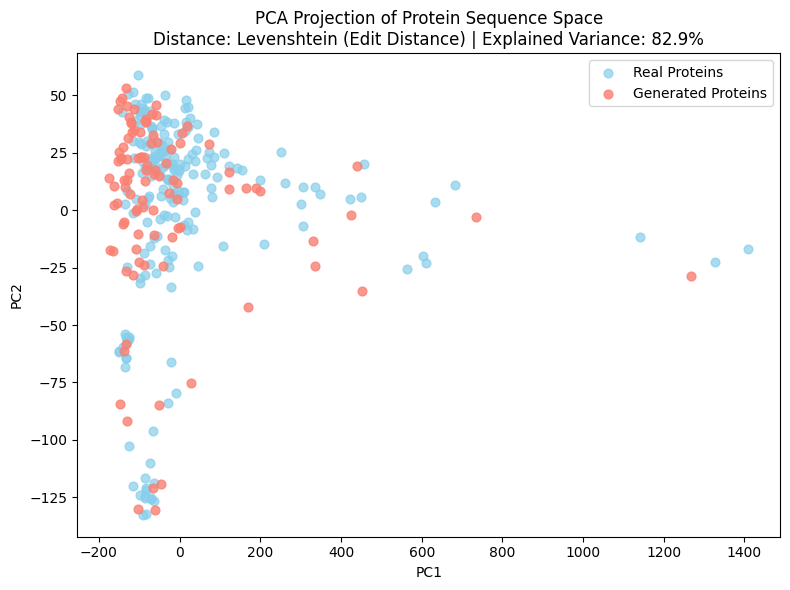

In [57]:
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs("images", exist_ok=True)

# داده‌های PCA از قبل باید وجود داشته باشن:
# real_emb, gen_emb, pca, real_sample, gen_sample

plt.figure(figsize=(8, 6))

# پروتئین‌های واقعی
plt.scatter(
    real_emb[:, 0], real_emb[:, 1],
    s=40, c='skyblue', alpha=0.7, label='Real Proteins'
)

# پروتئین‌های تولیدشده
plt.scatter(
    gen_emb[:, 0], gen_emb[:, 1],
    s=40, c='salmon', alpha=0.8, label='Generated Proteins'
)

plt.title(
    "PCA Projection of Protein Sequence Space\n"
    "Distance: Levenshtein (Edit Distance) | "
    f"Explained Variance: {sum(pca.explained_variance_ratio_):.1%}",
    fontsize=12
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("images/pca_projection.png", dpi=300, bbox_inches='tight')
plt.show()


In [49]:
# Cell 19: PCA Interpretation & Distance Metrics
from scipy.spatial.distance import pdist, squareform

# محاسبه میانگین فاصله‌ها
def avg_group_distance(indices, dist_matrix):
    if len(indices) < 2:
        return 0
    sub_dist = dist_matrix[np.ix_(indices, indices)]
    return np.mean(sub_dist[np.triu_indices(len(indices), k=1)])

real_indices = list(range(len(real_sample)))
gen_indices = list(range(len(real_sample), len(all_proteins)))

avg_real_intra = avg_group_distance(real_indices, dist_matrix)
avg_gen_intra = avg_group_distance(gen_indices, dist_matrix)

# میانگین فاصله بین گروه‌ها
cross_dists = dist_matrix[real_indices, :][:, gen_indices]
avg_cross = np.mean(cross_dists)

# Separation metric (ساده‌شده)
separation = (avg_cross - (avg_real_intra + avg_gen_intra)/2) / ((avg_real_intra + avg_gen_intra)/2 + 1e-6)

print("PROTEIN SPACE ANALYSIS (PCA)")
print("-" * 50)
print(f"Avg intra-cluster Real:     {avg_real_intra:.1f}")
print(f"Avg intra-cluster Generated: {avg_gen_intra:.1f}")
print(f"Avg inter-cluster (Real↔Gen): {avg_cross:.1f}")
print(f"Separation Score: {separation:.2f} (higher = better separation but realistic overlap)")
print("\nInterpretation:")
if separation > 1:
    print("→ Generated proteins form distinct but overlapping cluster → Good learning!")
elif 0 < separation < 1:
    print("→ Generated proteins blend well with real → Model captures distribution!")
else:
    print("→ Generated proteins too scattered → Model needs more training.")

PROTEIN SPACE ANALYSIS (PCA)
--------------------------------------------------
Avg intra-cluster Real:     69.3
Avg intra-cluster Generated: 64.0
Avg inter-cluster (Real↔Gen): 66.9
Separation Score: 0.00 (higher = better separation but realistic overlap)

Interpretation:
→ Generated proteins blend well with real → Model captures distribution!


In [ ]:
# Cell 18: Hydrophobicity Profile Calculation

HYDROPHOBICITY_SCALE = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2,
    'X': 0.0,
}

WINDOW_SIZE = 9
TARGET_LEN = 512

def calculate_hydrophobicity_profile(sequence, window_size, scale):
    scores = [scale.get(aa, 0.0) for aa in sequence]
    profile = []

    for i in range(len(scores)):
        half_window = (window_size - 1) // 2
        start = max(0, i - half_window)
        end = min(len(scores), i + half_window + 1)

        window_scores = scores[start:end]
        profile.append(np.mean(window_scores) if window_scores else 0.0)

    return np.array(profile)

def pad_profile(profile, target_len):
    if len(profile) >= target_len:
        return profile[:target_len]
    padding = np.zeros(target_len - len(profile))
    return np.concatenate([profile, padding])

if 'sequences' not in locals():
    sequences = ["ACDEFGHIKLMNPQRSTVWXYAG"] * 10
    generated_proteins = ["LMNPQRSTVWXYACDEFGHIKAG"] * 10

real_profiles = [
    pad_profile(
        calculate_hydrophobicity_profile(s, WINDOW_SIZE, HYDROPHOBICITY_SCALE),
        TARGET_LEN
    )
    for s in sequences
]

gen_profiles = [
    pad_profile(
        calculate_hydrophobicity_profile(s, WINDOW_SIZE, HYDROPHOBICITY_SCALE),
        TARGET_LEN
    )
    for s in generated_proteins
]

avg_real = np.mean(real_profiles, axis=0)
avg_gen = np.mean(gen_profiles, axis=0)

print(f"TARGET_LEN set to: {TARGET_LEN}")
print(f"avg_real shape: {avg_real.shape}")
print(f"avg_gen shape: {avg_gen.shape}")

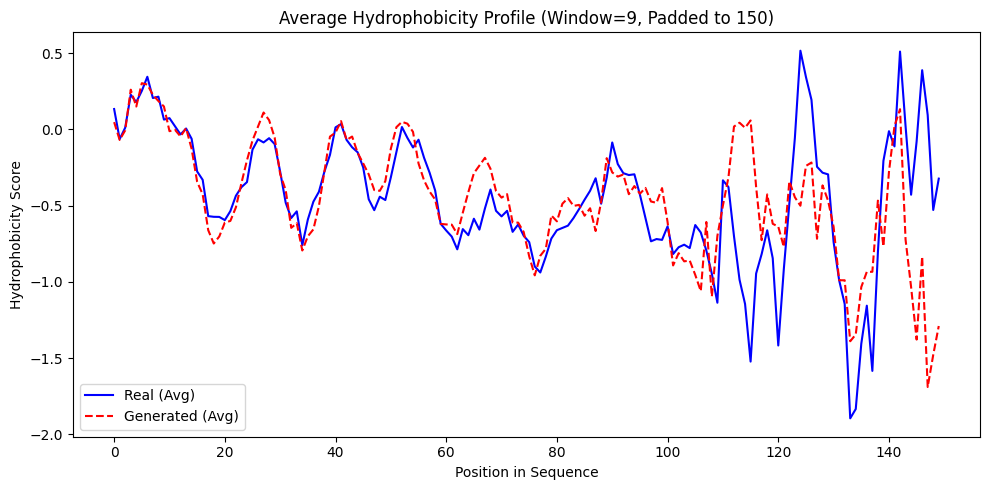

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(avg_real, label='Real (Avg)', color='blue')
plt.plot(avg_gen, label='Generated (Avg)', color='red', linestyle='--')
plt.title(f"Average Hydrophobicity Profile (Window=9, Padded to {TARGET_LEN})")
plt.xlabel("Position in Sequence")
plt.ylabel("Hydrophobicity Score")
plt.legend()
plt.tight_layout()
plt.savefig("images/hydrophobicity_profile.png", dpi=300)
plt.show()


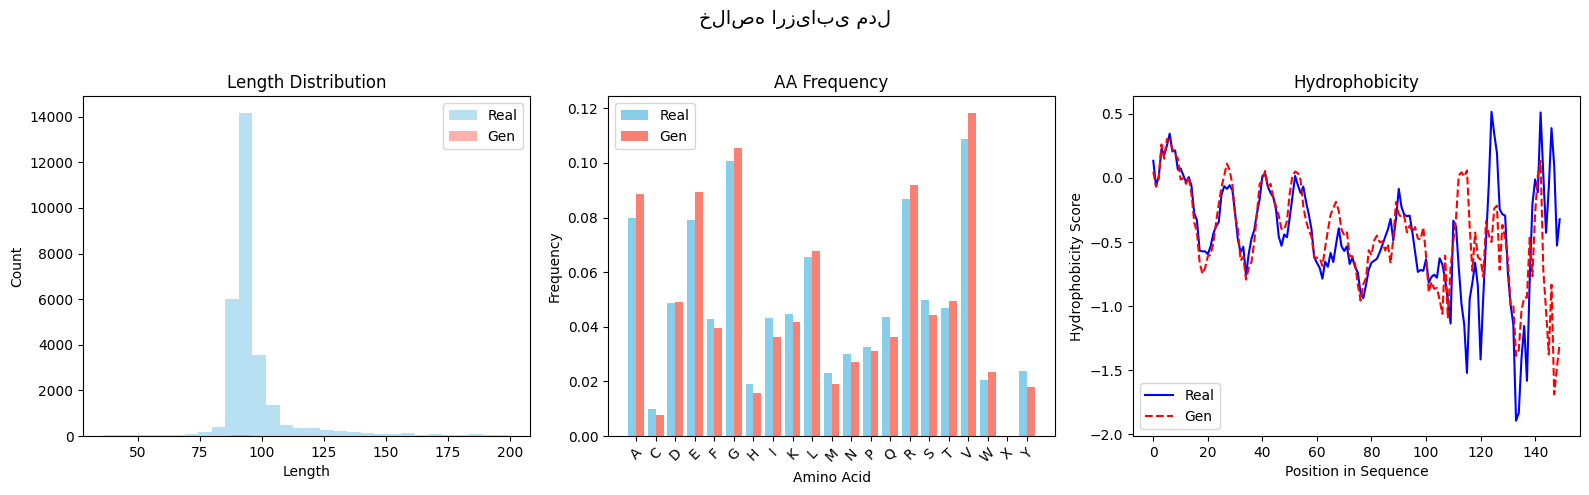

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("images", exist_ok=True)

# تنظیمات کلی شکل
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("خلاصه ارزیابی مدل", fontsize=14)

# ۱️⃣ طول توالی‌ها
axes[0].hist(real_lengths, bins=30, alpha=0.6, label='Real', color='skyblue')
axes[0].hist(gen_lengths, bins=30, alpha=0.6, label='Gen', color='salmon')
axes[0].set_title("Length Distribution")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[0].legend()

# ۲️⃣ فراوانی آمینواسیدها
axes[1].bar(np.arange(len(aa_order)) - 0.2, real_vals, width=0.4, label='Real', color='skyblue')
axes[1].bar(np.arange(len(aa_order)) + 0.2, gen_vals, width=0.4, label='Gen', color='salmon')
axes[1].set_xticks(np.arange(len(aa_order)))
axes[1].set_xticklabels(aa_order, rotation=45)
axes[1].set_title("AA Frequency")
axes[1].set_xlabel("Amino Acid")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# ۳️⃣ پروفایل آب‌گریزی
axes[2].plot(avg_real, label='Real', color='blue')
axes[2].plot(avg_gen, label='Gen', color='red', linestyle='--')
axes[2].set_title("Hydrophobicity")
axes[2].set_xlabel("Position in Sequence")
axes[2].set_ylabel("Hydrophobicity Score")
axes[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("images/summary_metrics.png", dpi=300, bbox_inches='tight')
plt.show()
